<!-- Assignment 1 - WS 2020 -->

# Regression in all Shapes and Sizes (17 points)

This notebook contains the first assignment for the exercises in Deep Learning and Neural Nets 1.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility function that should work without problems.
Please, do not alter this code or add extra import statements in your submission!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the goal is to get familiar with some of the simplest neural networks possible. 
Essentially, these simple networks come down to a well-known tool in statistics: **regression**.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from nnumpy import data

rng = np.random.default_rng(123)
%matplotlib inline

In [2]:
# visual functions
def show_1d_model(x, y, w, b, pred_func, err_func):
    """Visualise 1D model on data"""
    # visualise data
    plt.scatter(x, y, color='steelblue')
    
    # compute error
    logits = my_first_network(x, w, b)
    pred = pred_func(logits)
    err = np.mean(err_func(pred, y), axis=0).item()
    
    # plot network as function
    _x = np.linspace(x.min(), x.max())[:, None]
    _s = my_first_network(_x, w, b)
    _pred = pred_func(_s)
    plt.plot(_x, _pred, color='tomato', linewidth=3, 
             label='prediction (err = {:.4f})'.format(err))
    
    # prettification
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()

    
def show_2d_model(x, y, w, b, pred_func, err_func, cmap='viridis'):
    """Visualise 2D model on data"""
    # evaluate network in grid of points for contours
    _x = np.linspace(x.min(), x.max())
    _x1, _x2 = np.meshgrid(_x, _x)
    _x = np.c_[_x1.flat, _x2.flat]
    _s = my_first_network(_x, w, b)
    _pred = pred_func(_s)
    if _pred.shape[-1] > 1:
        # use softmax-weighted avg of labels for plotting
        _pred *= np.arange(_pred.shape[-1])
        _pred = np.sum(_pred, axis=-1)
    
    # visualise data and contours
    _pred = _pred.reshape(_x1.shape)
    vmin = min(_pred.min(), y.min())
    vmax = max(_pred.max(), y.max())
    plt.scatter(*x.T, c=np.squeeze(y), cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='w')
    plt.colorbar().set_label('$y$')
    plt.contour(_x1, _x2, _pred, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # compute error
    logits = my_first_network(x, w, b)
    pred = pred_func(logits)
    if pred.shape[-1] > 1:
        # compute error on one-hot values
        y = to_one_hot(y, pred.shape[-1])
    err = np.mean(err_func(pred, y), axis=0).item()
    
    # prettification
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(handles=[
        plt.Line2D([], [], color='black', 
                   label='prediction contours (err = {:.4f})'.format(err))
    ], loc='upper center')

## Linear Regression

Linear regression is a natural choice for modelling linear relationships in statistics. Ater all, it maximises the likelihood of a linear model if the noise in the data is assumed to be Gaussian. On top of that, the *Maximum Likelihood Estimator* can be written down analytically. Since this model corresponds to a single-layer neural network without activation function, it is a good starting point for exploring neural networks.

###### Model

Concretely, the outputs $\boldsymbol{y} \in \mathbb{R}^K$ are assumed to depend on the inputs $\boldsymbol{x} \in \mathbb{R}^D$ and random noise $\varepsilon_k \sim \mathcal{N}(0, \sigma^2)$ so that

$$\boldsymbol{y} = f(\boldsymbol{x}) + \boldsymbol{\varepsilon},$$

where $f : \mathbb{R}^D \to \mathbb{R}^K$ is some linear function. 
To model the underlying relationship $f$, we will use one of the simplest possible *Neural Networks*:

$$g(\boldsymbol{x} \mathbin{;} \theta) = \boldsymbol{w} \cdot \boldsymbol{x} + \boldsymbol{b},$$

where $\theta = \{\boldsymbol{w}, \boldsymbol{b}\}$ is the set of parameters for the model.
**Note** that this network corresponds to a linear regression model.

###### Likelihood

The *Likelihood* of a supervised machine learning model for a dataset with 
*identically and independenltly distributed* inputs $\boldsymbol{X}$ and outputs $\boldsymbol{Y}$ is given by

$$\mathcal{L}(\theta \mathbin{;} \boldsymbol{X}, \boldsymbol{Y}) = \prod_{n = 1}^{N} p(\boldsymbol{x}^n, \boldsymbol{y}^n \mathbin{;} \theta) = \prod_{n = 1}^{N} p(\boldsymbol{y}^n \mid \boldsymbol{x}^n \mathbin{;} \theta).$$

This likelihood quantises how likely some data is, given the parameters of a model.
Given the model assumptions as stated above, the conditional probablity 
in the likelihood product can be written as 

$$p(\boldsymbol{y}^n \mid \boldsymbol{x}^n \mathbin{;} \theta) = p_\mathcal{N}\left(\boldsymbol{y}^n \mathbin{;} g(\boldsymbol{x}^n \mathbin{;} \theta), \sigma^2\right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(\frac{-\left(\boldsymbol{y}^n - g(\boldsymbol{x}^n \mathbin{;} \theta)\right)^2}{2 \sigma^2}\right).$$

###### Optimisation

Maximising the likelihood, $\mathcal{L}(\theta)$, is equivalent to maximising the *log-likelihood*, $\mathcal{l}(\theta) = \ln \mathcal{L}(\theta)$, or minimising the additive inverse. Therefore, the optimal parameters, $\theta^*$ are specified by

$$\begin{aligned}
  \theta^* & = \arg\min_\theta \left\{-\mathcal{l}(\theta \mathbin{;} \boldsymbol{X}, \boldsymbol{Y}) \right\} \\
  & = \arg\min_\theta \left\{-\sum_{n = 1}^{N} \ln p(\boldsymbol{y}^n \mid \boldsymbol{x}^n \mathbin{;} \theta) \right\} \\
  & = \arg\min_\theta \left\{N \ln \sqrt{2 \pi \sigma^2} + \frac{1}{2 \sigma^2} \sum_{n = 1}^{N}\left(\boldsymbol{y}^n - g(\boldsymbol{x}^n \mathbin{;} \theta)\right)^2 \right\},
\end{aligned}$$

which is equivalent to minimising the sum of squared errors

$$\theta^* = \arg\min_\theta \left\{\frac{1}{2} \sum_{n = 1}^{N}\left(\boldsymbol{y}^n - g(\boldsymbol{x}^n \mathbin{;} \theta)\right)^2 \right\}.$$

### Exercise 1: Numpy Regression (2 Points)

The model described above should be straightforward to implement. How about you get familiar with [python](https://docs.python.org/3) and [numpy](https://docs.scipy.org/doc/numpy) (again)?

> Implement the simple neural network from above as well as the squared error loss, using `numpy`.

In [3]:
def squared_error(prediction, truth):
    """
    Compute the squared error of a predicted value, given the actual target.
    
    Parameters
    ----------
    prediction : (N, K) ndarrary
        The value(s) predicted by the model.
    truth : (N, K) ndarray
        The actual target(s) from the data.
        
    Returns
    -------
    error : (N, K) ndarray
        The squared error(s) for the prediction(s).
    """
    error = (truth-prediction)**2 / 2 # because of derivative should be devide by 2
    return error
    raise NotImplementedError("TODO: implement squared_error function!")


def my_first_network(x, w, b):
    """
    Predict a value for some input with a simple neural network.
    
    Parameters
    ----------
    x : (N, D) ndarray
        The input samples to predict a value for.
    w : (K, D) ndarray
        The input parameters for the neural network.
    b : (K, ) ndarray
        The bias parameter for the neural network.
        
    Returns
    -------
    prediction : (N, K) ndarray
        The predicted value for the input from the network.
    """
    prediction = x@w.T+b  # np.matmul(x,w.T)+b
    return prediction
    raise NotImplementedError("TODO: implement my_first_network function!")

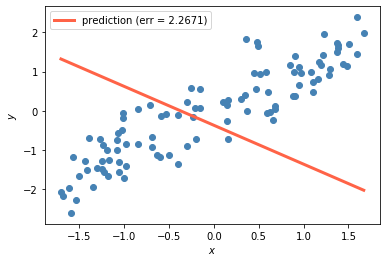

In [4]:
# visualisation
x, y = data.gen_linear_data(num_dimensions=1, seed=1856)
w = rng.normal(0, 1, (y.shape[1], x.shape[1]))
b = rng.normal(0, 1, y.shape[1])

show_1d_model(x, y, w, b, lambda x: x, squared_error)

### Exercise 2: Analytical Solution (3 Points)

Minimising the negative log-likelihood comes down to solving linear regression with the *least-squares* method, i.e. by minimising the sum of squared residuals. For the least-squares method in linear regression, the optimal parameters can be derived analytically. The optimal solution is given by:

$$\theta^* = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{Y}.$$

Does this model incorporate a bias parameter? Where can the bias parameter be found?

> Implement the `analytical_solution` function so that it computes this analytical solution for given inputs and outputs. The function should allow solutions both with and without bias parameter.

**Hint:** to get help for commands, execute a cell with following code (for help on `np.linalg.inv`):
```python
?np.linalg.inv
```

In [5]:
def analytical_solution(x, y, bias=True):
    """
    Get the optimal parameters for linear regression,
    given input data and target values.
    
    Parameters
    ----------
    x : (N, D) ndarray
        Input data to the network.
    y : (N, K) ndarray
        Target values.
    bias : bool, optional
        Whether or not the network should have a bias term.
        
    Returns
    -------
    w : (K, D) ndarray
        The optimal input parameters for the network.
    b : (K, ) ndarray
        The optimal bias parameters for the network
        or zero if `bias=False`.
    """
    if bias:
        # To consider the bias it needs to add a one column to the x,
        x_ext = np.concatenate((np.ones(x.shape[0]).reshape(-1,1),x), axis=1)
        x_pinv = np.linalg.inv(x_ext.T@x_ext)@x_ext.T
        theta_ml = x_pinv @y
        # then  y = b + wx where b is bias
        b = theta_ml[0]
        w_ml = theta_ml[1:]
    else:
        x_pinv = np.linalg.inv(x.T@x)@x.T
        w_ml = x_pinv @y # np.matmul(x_pinv, y)
        b = np.zeros(y.shape[1])
    
    # The parameters should be the size of [output units, input units] 
    w = w_ml.T  # reshape(y.shape[1], x.shape[1])
    return w, b
    raise NotImplementedError("TODO: implement analytical_solution function!")

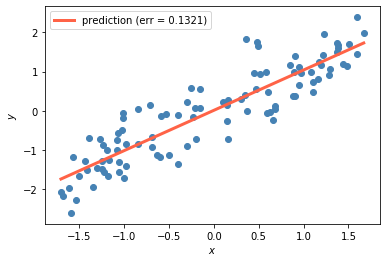

In [6]:
# visualisation
x, y = data.gen_linear_data(num_dimensions=1, seed=1856)
w, b = analytical_solution(x, y, bias=True)

show_1d_model(x, y, w, b, lambda x: x, squared_error)

### Exercise 3: Importance of Bias (1 Point)

Whether `bias=True` or `bias=False` in the fragment above, there seems to be little difference. Why is it important to have a bias parameter? 

> Configure the arguments for generating data below to illustrate the problem of not having a bias parameter.

**Note:** The plots below are [contour plots](https://en.wikipedia.org/wiki/Contour_line). The colours encode the value of the function in each point.

In [7]:
# TODO: configure the arguments of the following function
x, y = data.gen_linear_data(
    num_samples=100,  # number of samples
    centre=(1, 3),    # input and output shifts, resp.
    scale=(2, 1),     # input and output scales, resp.
    log_snr=3,        # log10 of signal to noise ratio
    seed=1856         # seed for random number generator
)

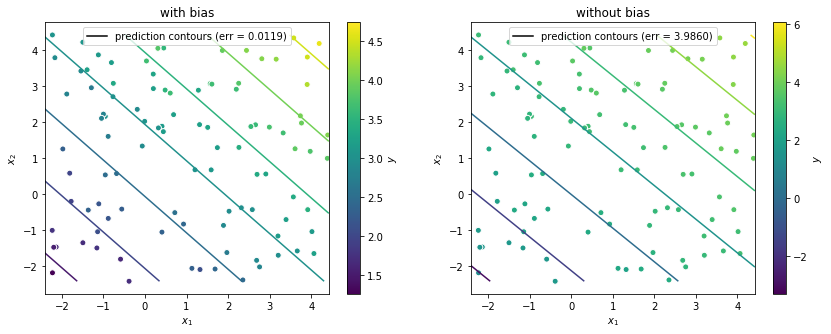

In [8]:
plt.figure(figsize=(14, 5))  # you can change figure dimensions if necessary

# visualise model with bias
w, b = analytical_solution(x, y, bias=True)
plt.subplot(121)
plt.title('with bias')
show_2d_model(x, y, w, b, lambda x: x, squared_error)

# visualise model without bias
w, b = analytical_solution(x, y, bias=False)
plt.subplot(122)
plt.title('without bias')
show_2d_model(x, y, w, b, lambda x: x, squared_error)

## Logistic Regression

The values to predict are not always continuous. A very common task in machine learning is to answer yes-no questions, e.g. Is this an image of a cat? These problems are known as *binary classification* tasks. This can be encoded by labelling positive examples with a 1 and negative examples with a 0. As a result, the target values are Bernoulli distributed, rather than Gaussian. This also means that the relationship is no longer linear and linear regression makes little sense. This is where *Logistic Regression* comes in play.

###### Model

Mathematically, we assume that the relation between inputs and outputs can be modelled as follows:

$$y = \begin{cases}
  1 & f(\boldsymbol{x}) > 0.5 \\
  0 & f(\boldsymbol{x}) \leq 0.5
\end{cases}.$$

Since the relation is non-linear, we add an additional non-linearity, $\sigma : \mathbb{R} \to \mathbb{R}$, to our simple network so that

$$g(\boldsymbol{x} \mathbin{;} \theta) = \sigma\left(\boldsymbol{w} \cdot \boldsymbol{x} + \boldsymbol{b}\right),$$

where the parameters are again $\theta = \{\boldsymbol{w}, \boldsymbol{b}\}$. The non-linear function maps real values to values between zero and one. This allows the outputs of the network to be interpreted as the probability for its input to be classified as positive. For logistic regression, this non-linearity is the logistic sigmoid, which is defined as 

$$\sigma(x) = \frac{1}{1 + e^{-x}}.$$

In [9]:
def logistic_sigmoid(s):
    """
    Compute the logistic sigmoid function.
    
    Parameters
    ----------
    s : ndarray
        The logits to apply the logistic sigmoid function on.
     
    Returns
    -------
    a : ndarray
        The probabilitie(s) for the given logit(s).
    """
    return 1 / (1 + np.exp(-s))

### Exercise 4: Logistic Likelihood Maximisation (3 Points)


Just as for linear regression, maximum likelihood estimation can be used to find parameters for a model that solves the binary classification problem. Is there an error function for logistic regression, like we have the squared error for linear regression? Time to try out some [$\LaTeX$](https://www.overleaf.com/learn)!

> Derive the optimisation objective for maximum likelihood in a similar way the squared error was derived for linear regression. Implement the resulting *logistic error* in the `logistic_error` function.


To derive the maximum likelihood estimator, we need the conditional probability of the label:
$$p(\boldsymbol{y}^n \mid \boldsymbol{x}^n \mathbin{;} \theta) = g(\boldsymbol{x}^n \mathbin{;} \theta)^{\boldsymbol{y}^n} \left(1-g(\boldsymbol{x}^n \mathbin{;} \theta)\right)^{\left(1-\boldsymbol{y}^n\right)}$$

The negative log-likelihood is then given by:
$$\begin{aligned}
  -\mathcal{l}(\theta \mathbin{;} \boldsymbol{X}, \boldsymbol{Y})
  & = -\sum_{n = 1}^{N} \ln p(\boldsymbol{y}^n \mid \boldsymbol{x}^n \mathbin{;} \theta) \\
  & =  -\sum_{n=1}^{N} \boldsymbol{y}^n \ln \left(g(\boldsymbol{x}^n \mathbin{;} \theta)\right) +\left(1-\boldsymbol{y}^n\right) \ln \left(1-g(\boldsymbol{x}^n \mathbin{;} \theta)\right)
\end{aligned}$$

**Hint**: the probability mass function of the Bernoulli distribution, $p_\mathrm{B}(k \mathbin{;} p) = \begin{cases} 1 - p & k = 0 \\ p & k = 1 \end{cases}$, can be written as $p_\mathrm{B}(k \mathbin{;} p) = p^k (1 - p)^{1 - k}$

##### Some Notes on LaTeX in Jupyter Notebooks

$\LaTeX$ is an advanced typesetting system that can be used for all sorts of documents. One of the key features of $\LaTeX$ is the ability to insert mathematical formulas in the text. Jupyter notebooks allow to display mathematical symbols (and some other things) through $\LaTeX$ syntax. Technically the conversion from $\LaTeX$ code to HTML is done by [MathJax](https://www.mathjax.org/), so if you cannot see the nice formulas I put in this notebook, you might need to troubleshoot MathJax.

To give you an idea of the possibilities of $\LaTeX$:

| code                   | rendered             | code (big)               | rendered (big)         |
|:---------------------- | --------------------:|:------------------------ | ----------------------:|
| `$\LaTeX$`             | $\LaTeX$             |                          |                        |
| `$\ln \boldsymbol{x}$` | $\ln \boldsymbol{x}$ | `$$\ln \boldsymbol{x}$$` | $$\ln \boldsymbol{x}$$ |
| `$\frac{a}{b}$`        | $\frac{a}{b}$        | `$$\frac{a}{b}$$`        | $$\frac{a}{b}$$        |
| `$\sum_{i=1}^I i^2$`   | $\sum_{i=1}^I i^2$   | `$$\sum_{i=1}^I i^2$$`   | $$\sum_{i=1}^I i^2$$   |

If you have troubles to find the right symbols, you can use [detexify](http://detexify.kirelabs.org/classify.html) or directly use a more graphical $\LaTeX$ equation editor, e.g. [this one from codecogs](https://www.codecogs.com/latex/eqneditor.php)

In [10]:
def logistic_error(prediction, truth):
    """
    Compute the logistic error of a predicted value, given the actual target.
    
    Parameters
    ----------
    prediction : (N, K) ndarrary
        The value(s) predicted by the model.
    truth : (N, K) ndarray
        The actual target(s) from the data.
        
    Returns
    -------
    error : (N, K) ndarray
        The logistic error(s) for the prediction(s).
    """
    # Hint: check the sign!
    error = -(truth * np.log(prediction) + (1 - truth) * np.log(1 - prediction))
    return error
    raise NotImplementedError("TODO: implement logistic_error function!")

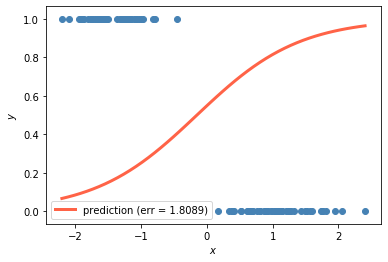

In [11]:
# visualisation
x, y = data.gen_blob_data(num_dimensions=1, seed=1856)
w, b = rng.normal(0, 1, (1, x.shape[1])), rng.normal(0, 1, 1)

show_1d_model(x, y, w, b, logistic_sigmoid, logistic_error)

### Exercise 5: Gradient Descent (3 Points)

Since there is no closed form solution for logistic regression, other methods are necessary to find the optimal parameters. Gradient descent is one of the simplest methods to get to a good solution. By pushing the parameters in the opposite direction of the gradient, it is possible to find local minima relatively fast.

Concretely, the gradient descent algorithm computes the gradients for some inputs and moves a certain amount in the direction of that gradient. This process is repeated a number of times until convergence. The amount of gradient to go down is known as the *learning rate*, and a single step of computing gradients and updating parameters is commonly called an *epoch*.

> Compute the derivatives for the parameters in logistic regression. Implement the `logistic_grad_func` so that it returns the derivatives of the logistic error w.r.t. the parameters. Make sure not to forget any parameters in the gradient descent!

In [12]:
def gradient_descent(grad_func, x, y, bias=True, epochs=10, lr=1.):
    """
    Use gradient descent to compute the weights of a network.
    
    Parameters
    ----------
    grad_func : callable
        Function that computes the error and gradients for the model.
        Signature should correspond to `err, grads = step_func(x, y, w, b)`.
    x : ndarray
        Inputs to the network.
    y : ndarray
        Targets for the network.
    bias : bool, optional
        Whether or not the network should have a bias term.
    epochs : int, optional
        Number of steps to descent.
    lr : float, optional
        Scaling factor for gradient steps.
        
    Returns
    -------
    w : ndarray
        The optimal input parameters for the network.
    b : ndarray, optional
        The optimal bias parameters for the network.
        Only returned if `bias=True`.
    """
    # initial guess for parameters
    w = np.zeros((y.shape[1], x.shape[1]))
    b = np.zeros(y.shape[1])
    
    for i in range(epochs):
        err, (dw, db) = grad_func(x, y, w, b)
        
        w -= lr * dw
        if bias:
            b -= lr * db
            
        # print mean error at most 5 times during learning
        if epochs < 5 or i % (epochs // 5) == 0:
            avg_err = np.mean(err, axis=0).item()
            print("epoch {:03d}: {:.4f}".format(i, avg_err))
        
    return w, b


def logistic_grad_func(x, y, w, b):
    """
    Compute the gradient of the logistic error w.r.t. the parameters.
    
    Parameters
    ----------
    x : (N, D) ndarray
        Inputs to the network.
    y : (N, K) ndarray
        Targets for the network.
    w : (K, D) ndarray
        Input weights of the network.
    b : (K, ) ndarray
        Bias weights of the network.
        
    Returns
    -------
    err : (N, K) ndarray
        The error of the prediction from the network 
        for the given input data before the update.
    grads : ((K, D) ndarray, (K, ) ndarray)
        Gradients of the logistic error function w.r.t. the parameters,
        i.e. `dw` and `db` (in that order).
        
    """
    logits = my_first_network(x, w, b)
    pred = logistic_sigmoid(logits)
    err = logistic_error(pred, y)
    
    dw = (pred - y).T@x
    db = np.sum(pred - y, axis=0)
    # raise NotImplementedError("TODO: implement logistic_gradfunc function!")
    return err, (dw, db)


def logistic_gradient_descent(x, y, bias=True, epochs=10, lr=1e-3):
    return gradient_descent(logistic_grad_func, x, y, bias, epochs, lr)

epoch 000: 0.6931
epoch 020: 0.3062
epoch 040: 0.1971
epoch 060: 0.1476
epoch 080: 0.1191


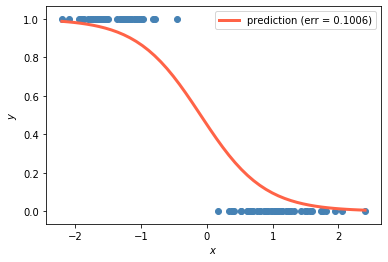

In [13]:
# visualisation
x, y = data.gen_blob_data(num_dimensions=1, seed=1856)
w, b = logistic_gradient_descent(x, y, epochs=100, bias=True)

show_1d_model(x, y, w, b, logistic_sigmoid, logistic_error)

## Softmax Regression

Softmax regression is essentially a generalisation of binary logistic regression that allows to solve *multi-class problems*, i.e. questions with more than two possible (exclusive) answers. Instead of predicting a single probability, the goal in softmax regression is to predict a probability for each of the possible classes. 

### Exercise 6: One-hot Encoding (1 Point)

Since the labels are mostly integer values, some encoding is necessary to have the targets reflect probabilities. E.g. if there are three classes, the labels would be `0`, `1`, `2`. The most common way to encode these labels as probability vectors is to use a one-hot encoding. A one-hot code uses as much bits as there are labels. The code is zero everywhere, except at the index that corresponds to the label, where it is one. E.g. in the case of the three zero-indexed labels, the encoding for the label `1` would be `[0, 1, 0]`

> Implement a function to compute one-hot encodings from integer labels.

In [14]:
def to_one_hot(y, k=None):
    """
    Compute a one-hot encoding from a vector of integer labels.
    
    Parameters
    ----------
    y : (N, 1) ndarray
        The zero-indexed integer labels to encode.
    k : int, optional
        The number of distinct labels in `y`.
        
    Returns
    -------
    one_hot : (N, k) ndarray
        The one-hot encoding of the labels.
    """
    n = len(y)
    if k is None:
        k = len(np.unique(y))
    
    one_hot = np.zeros((n, k), dtype=y.dtype)
    for cnt in range(n):
        one_hot[cnt, y[cnt]]=1
    # raise NotImplementedError("TODO: implement to_one_hot function!")
    
    return one_hot

In [15]:
y = rng.integers(3, size=(5, 1))
print("original y:")
print(y.ravel())
print("result:")
print(to_one_hot(y, 3))

original y:
[1 0 1 2 1]
result:
[[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]]


###### Model

One possible way to model multiple output classes, is to consider a function $f : \mathbb{R}^D \to \mathbb{R}^K$, where $K$ is the number of labels, which allows to specify the model as follows

$$y = \arg\max_i f_i(\boldsymbol{x}).$$

Note that every binary decision problem can be formulated as a multi-class problem with two classes. To extend the logistic sigmoid non-linearity to multiple classes, we can consider how the prediction for the negative class can be computed. Assuming the probability of the positive class is computed by:
$$\sigma\left(s\right) = \frac{1}{1 + e^{-s}},$$
the probability of the negative class is given by:
$$1 - \sigma\left(s\right) = \frac{e^{-s}}{1 + e^{-s}} = \sigma(-s).$$

The non-linearity that is the result of generalising the logistic sigmoid,
$$\mathrm{softmax}_i(\boldsymbol{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}},$$
is known as the *softmax* function and it can be verified that $\mathrm{softmax}(\,(x, 0)\,) = (\sigma(x), \sigma(-x))$.

###### Likelihood

The Likelihood for softmax regression can be derived in a similar was as you have done it for logistic regression --- using a categorical instead of a Bernoulli distribution. Assuming that the labels, $\boldsymbol{y}$, are given as one-hot vectors, the resulting negative log-likelihood is known as the *cross entropy* loss:

$$-l(\theta \mathbin{;} \boldsymbol{X}, \boldsymbol{Y}) = \sum_{n=1}^N \boldsymbol{y}^n \ln g(\boldsymbol{x}^n \mathbin{;} \theta)$$

### Exercise 7: Softmax Gradients (4 Points)

Time to generalise logistic gradient descent to handle multiple labels! Either you remember these functions from the lecture or you can freshen up your memory in the script. 

> Implement the functions necessary for training a softmax classifier with gradient descent. Make sure not to forget any parameters in the gradient descent!

In [16]:
def softmax(s):
    """
    Compute the softmax function.
    
    Parameters
    ----------
    s : (N, K) ndarray
        The logits to apply the softmax function on.
    
    Returns
    -------
    a : (N, K) ndarray
        The probabilitie(s) for the given logit(s).
    """
    # Hint: check the row sums!
    # a = (np.exp(s.T)/np.sum(np.exp(s.T), axis=0)).T
    a = np.zeros(s.shape)
    for kk in range(s.shape[1]):
        a[:,kk] = np.exp(s[:,kk]) / np.sum(np.exp(s), axis=1)
    return a
    raise NotImplementedError("TODO: implement softmax function!")


def cross_entropy(prediction, truth):
    """
    Compute the logistic error of a predicted value, given the actual target.
    
    Parameters
    ----------
    prediction : (N, K) ndarrary
        The value(s) predicted by the model.
    truth : (N, K) ndarray
        The actual target(s) from the data.
        
    Returns
    -------
    error : (N, ) ndarray
        The logistic error(s) for the prediction(s).
    """
    # Hint: check the sign!
    error = - np.sum(truth * np.log(prediction), axis=1)
    return error
    raise NotImplementedError("TODO: implement cross_entropy function!")


def softmax_grad_func(x, y, w, b):
    """
    Compute the gradient of the cross-entropy w.r.t. the parameters.
    
    Parameters
    ----------
    x : (N, D) ndarray
        Inputs to the network.
    y : (N, K) ndarray
        Targets for the network.
    w : (K, D) ndarray
        Input weights of the network.
    b : (K, ) ndarray
        Bias weights of the network.
        
    Returns
    -------
    err : (N, ) ndarray
        The error of the prediction from the network 
        for the given input data before the update.
    grads : ((K, D) ndarray, (K, ) ndarray)
        Gradients of the logistic error function w.r.t. the parameters,
        i.e. `dw` and `db` (in that order).
    """
    logits = my_first_network(x, w, b)
    pred = softmax(logits)
    err = cross_entropy(pred, y)
    
    dw = (pred - y).T@x
    db = np.sum(pred - y, axis=0)
    return err, (dw, db)
    raise NotImplementedError("TODO: implement softmax_grad_func function!")

def softmax_gradient_descent(x, y, bias=True, epochs=10, lr=1e-3):
    return gradient_descent(softmax_grad_func, x, y, bias, epochs, lr)

epoch 000: 0.6931
epoch 020: 0.1631
epoch 040: 0.1150
epoch 060: 0.0953
epoch 080: 0.0843


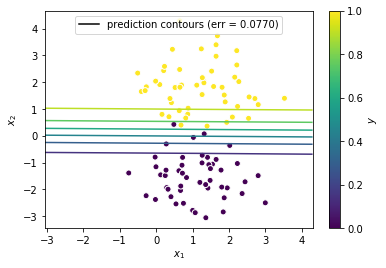

In [17]:
# feel free to play around with this code!
num_samples = (50, 50)
x, y = data.gen_blob_data(num_samples, std=1., seed=1856)
y_hot = to_one_hot(y, k=len(num_samples))
w, b = softmax_gradient_descent(x, y_hot, epochs=100, bias=True)
show_2d_model(x, y, w, b, softmax, cross_entropy)